### 딥러닝을 이용한 주가 추정
* NN: Neural Network: 신경망
* DNN: Deep NN: 심층 신경망
* CNN: Convolution NN: 합성곱 신경망
* RNN: Reucrrent NN: 순환 신경망
    - LSTM


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
##>old d=[skey,'003490','대한항공',sday,sendp,sstartp,shighp,slowp,svol]
#d=[skey,'003490','대한항공',sday,sstartp,shighp,slowp,sendp,svol]
# 데이터 베이스 사용하기 SQLITE3
startday='1990-07-01'
def seldata(dstart=startday,dend='2021-12-20'):
    dbname='../_db/stockdb.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        cols='sday,sopenp,shighp,slowp,sclosep,svol'
        selsql="select "+cols+" from stockp where sday>='"+dstart+"' and sday<='"+dend+"' order by sday asc"
        sdata=cur.execute(selsql).fetchall()
    return sdata

In [3]:
sdata=seldata()
cols=['sday','sclosep','sopenp','shighp','slowp','svol']
sdf=pd.DataFrame(sdata,columns=cols)
tdf=sdf.set_index('sday')
tdf.tail()

,sclosep,sopenp,shighp,slowp,svol
sday,,,,,
2021-12-14,29000,28900,29150,28500,1218529
2021-12-15,29100,28900,29300,28850,813436
2021-12-16,29000,29200,29200,28750,831523
2021-12-17,29200,28800,29350,28700,1143242
2021-12-20,28700,29050,29050,28650,800452


In [12]:
k=5

closek=list(tdf['sclosep'].rolling(k))
seed=closek[0][0]
X=[]
y=[]
for ar in closek:
    for i in range(k-len(ar)):
        #print(ar)
        ar=np.insert(list(ar),0,seed)
    y.append(ar[-1])
    X.append(list(ar))
    Y=y[1:]
    Y.append(y[-1])
X=np.array(X)
Y=np.array(Y)
print(X[-3:],Y[-3:])


[[29400 29300 29000 29100 29000]
 [29300 29000 29100 29000 29200]
 [29000 29100 29000 29200 28700]] [29200 28700 28700]


(15000.0, 20000.0)

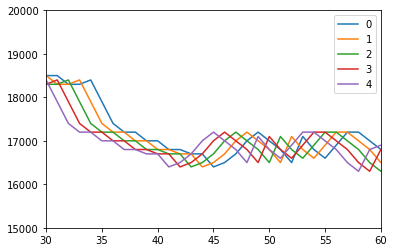

In [6]:
xdf=pd.DataFrame(X)
xdf.plot()
plt.xlim(30,60)
plt.ylim(15000,20000)

In [13]:
from sklearn.model_selection import train_test_split
cutratio=0.2
cut=-int(np.ceil(len(X)*cutratio))
print(-cut)
x=X.reshape(X.shape[0],X.shape[1],-1)
X_train=np.array(x[:cut])
y_train=np.array(Y[:cut])
X_test=np.array(x[cut:])
y_test=np.array(Y[cut:])
print(X_train.shape)


1279
(5113, 5, 1)


In [14]:

print(X_train.shape,X_train[1])

(5113, 5, 1) [[18800]
 [18800]
 [18800]
 [18800]
 [18600]]


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
model=Sequential()
model.add(LSTM(64,
               input_shape=(X_train.shape[1],X_train.shape[2]),
               activation='relu'
              )
         )
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['CosineSimilarity']
             )
hist=model.fit(X_train,y_train,epochs=100,batch_size=100)

Epoch 1/100
52/52 [==============================] - 0s 2ms/step - loss: 286247488.0000 - cosine_similarity: 1.0000
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 3298156.7500 - cosine_similarity: 1.0000
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 2572418.5000 - cosine_similarity: 1.0000
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 2471218.0000 - cosine_similarity: 1.0000
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 2736783.7500 - cosine_similarity: 1.0000
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 2155257.7500 - cosine_similarity: 1.0000
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 2211715.0000 - cosine_similarity: 1.0000
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 2196044.0000 - cosine_similarity: 1.0000
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 2054408.5000 

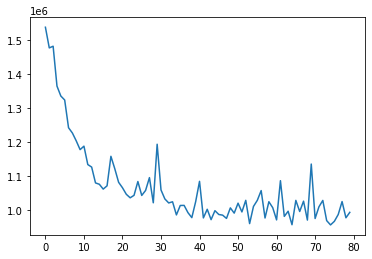

In [30]:
plt.plot(hist.history['loss'][20:])

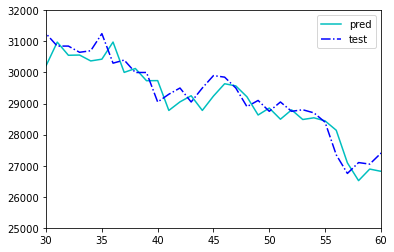

In [31]:

pred=model.predict(X_test)
plt.plot(pred,'c-',label='pred')
plt.plot(y_test,'b-.',label='test')
plt.xlim(30,60)
plt.ylim(25000,32000)
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.metrics.pairwise import cosine_similarity

#acc=np.round(accuracy_score(pred,y_test),4)
def testeval(pred,y_test):
    mse=np.round(mean_squared_error(pred,y_test),4)
    r2=np.round(r2_score(pred,y_test),4)

    pred_m=pred.reshape(1,-1)
    y_test_m=y_test.reshape(1,-1)

    cos=np.round(cosine_similarity(pred_m,y_test_m),4)
    print('mse:',mse,'r2:',r2)
testeval(pred,y_test)

mse: 546589.1036 r2: 0.9791


In [181]:
from sklearn.ensemble import RandomForestRegressor
rfmodel=RandomForestRegressor(n_estimators=100)
rfmodel.fit(X_train,y_train)
rfpred=rfmodel.predict(X_test)

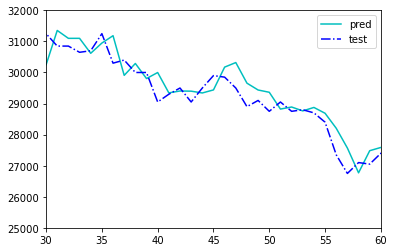

In [182]:
plt.plot(rfpred,'c-',label='pred')
plt.plot(y_test,'b-.',label='test')
plt.xlim(30,60)
plt.ylim(25000,32000)
plt.legend()
plt.show()

In [183]:
testeval(rfpred,y_test)

mse: 508338.3321 r2: 0.9808


In [134]:
# 2개월간 10

beforepos=-1 # 밴드 포지션 1:상단통과 0 밴드내부 -1 하단통과 
beforehold=0 # 주식 보유여부
for i,row in wdf.iloc[:,:].iterrows():
    #print(i,'\n',row)
    if row['slowK']>row['slowD']:
        nowpos=1 ## 매수 포지션
    else:
        nowpos=-1
    if(row['slowD']==0):
        nowpos=-1
        
    wdf.loc[i,'nowpos']=nowpos # 현재 포지션
    if nowpos > -1 and beforepos==-1 and beforehold==0: # 매수신호
        timing=1
        hold=1
        wdf.loc[i,'cash']=-row['sclosep']
    elif nowpos < 1 and beforepos==1 and beforehold==1:
        timing=-1
        hold=0
        wdf.loc[i,'cash']=row['sclosep']
    else:
        timing=0
        hold=beforehold
        wdf.loc[i,'cash']=0
        
    wdf.loc[i,'hold']=hold # 주식 보유 여부
    wdf.loc[i,'timing']=timing
    beforepos=nowpos
    beforehold=hold
wdf.loc[startday,'cash']=32000
wdf['cumcash']=wdf['cash'].cumsum()
wdf['balance']=wdf['sclosep']*wdf['hold']+wdf['cumcash']
scols=['sclosep','SPK','nowpos','timing','hold','cash','cumcash','balance']
print('시작가:',wdf['sclosep'][0],
      ' 종가:',wdf['sclosep'][-1],
      '차이:',wdf['sclosep'][-1]-wdf['sclosep'][0],
      '잔고:',wdf['balance'][-1],
      '수익:',wdf['balance'][-1]-wdf['balance'][0],
     )
wdf[scols].head(30)


시작가: 31250  종가: 28700 차이: -2550 잔고: 31400.0 수익: -600.0


,sclosep,SPK,nowpos,timing,hold,cash,cumcash,balance
sday,,,,,,,,
2021-07-01,31250,0.00,-1.0,0.0,0.0,32000.0,32000.0,32000.0
2021-07-02,31350,0.00,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-05,31850,0.00,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-06,32250,0.00,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-07,31500,0.21,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-08,31000,0.00,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-09,30300,0.18,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-12,30500,0.25,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-13,30950,0.55,1.0,1.0,1.0,-30950.0,1050.0,32000.0
